In [2]:
#@title 1.3. IMPORT LIBRARY

import sys
sys.path.append('../utils')
from data_retrieval import data_retrieval
from neural_net import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchmetrics import Accuracy

from kan import *
torch.set_default_dtype(torch.float64)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cpu


In [3]:
df = data_retrieval()
df.head()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,Risk
0,2.766456,0.146949,-0.745131,-1.236478,0.176948,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
1,-1.191404,0.146949,0.949817,2.248194,-0.284901,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
2,1.183312,-1.383771,-0.416562,-0.738668,0.045495,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
3,0.831502,0.146949,1.634247,1.750384,0.130233,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1
4,1.535122,0.146949,0.566664,0.256953,0.229637,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0


checkpoint directory created: ./model
saving model version 0.0


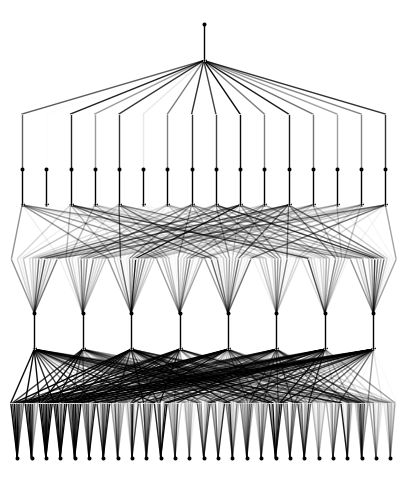

In [11]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
X_train, y_train = df_train.drop(columns='Risk'), df_train['Risk']
X_test, y_test = df_test.drop(columns='Risk'), df_test['Risk']

dataset = dict()
dataset['train_input'] = torch.tensor(X_train.values)
dataset['train_label'] = torch.tensor(y_train.values)
dataset['test_input'] = torch.tensor(X_test.values)
dataset['test_label'] = torch.tensor(y_test.values)

model = KAN(width=[27,8,16,1], grid=3, k=3, seed=42, device=device)
model(dataset['train_input'])
model.plot()

In [12]:
model.fit(dataset, opt="Adam", steps=100, lamb=0.02)

| train_loss: 1.72e+00 | test_loss: 9.20e+00 | reg: 1.68e+03 | : 100%|█| 100/100 [00:05<00:00, 18.71


saving model version 0.1


{'train_loss': [array(0.89543048),
  array(35.95928485),
  array(129.80293211),
  array(86.00472795),
  array(47.32599705),
  array(78.47811315),
  array(202.17007991),
  array(204.23270517),
  array(655.57992264),
  array(43.88304774),
  array(44.68591312),
  array(107.70219911),
  array(48.56512797),
  array(67.43477521),
  array(18.06656658),
  array(22.03794625),
  array(30.14175378),
  array(53.59811954),
  array(37.40834778),
  array(60.74159091),
  array(48.06519057),
  array(105.48942374),
  array(94.05037744),
  array(67.43357931),
  array(156.53720952),
  array(148.4686123),
  array(75.04479138),
  array(50.60838414),
  array(30.91172884),
  array(43.06583643),
  array(40.92732316),
  array(24.73338623),
  array(138.97651922),
  array(94.19348392),
  array(56.79021166),
  array(45.5607815),
  array(41.24443756),
  array(29.58396688),
  array(33.35755684),
  array(24.22400832),
  array(26.46948557),
  array(19.08007928),
  array(19.31689847),
  array(20.92627488),
  array(23.0

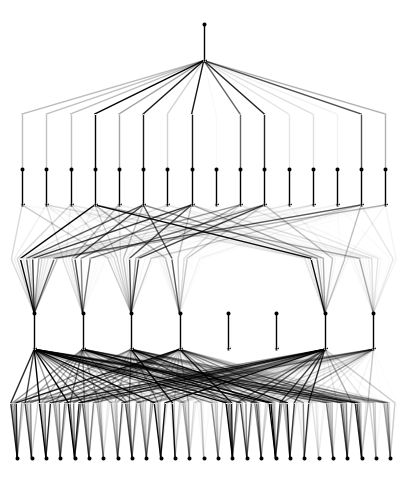

In [13]:
model.plot()

saving model version 0.2


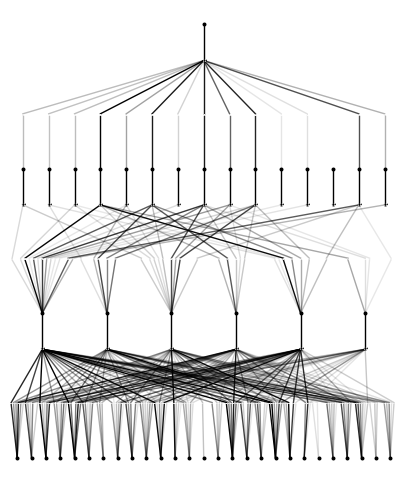

In [7]:
model = model.prune()
model.plot()

In [8]:
model = model.refine(10)

saving model version 0.3


In [9]:
model.fit(dataset, opt="Adam", steps=50)

| train_loss: nan | test_loss: nan | reg: nan | : 100%|█████████████| 50/50 [00:03<00:00, 16.02it/s]

saving model version 0.4


{'train_loss': [array(33.86779287),
  array(nan),
  array(nan),
  array(nan),
  array(nan),
  array(nan),
  array(nan),
  array(nan),
  array(nan),
  array(nan),
  array(nan),
  array(nan),
  array(nan),
  array(nan),
  array(nan),
  array(nan),
  array(nan),
  array(nan),
  array(nan),
  array(nan),
  array(nan),
  array(nan),
  array(nan),
  array(nan),
  array(nan),
  array(nan),
  array(nan),
  array(nan),
  array(nan),
  array(nan),
  array(nan),
  array(nan),
  array(nan),
  array(nan),
  array(nan),
  array(nan),
  array(nan),
  array(nan),
  array(nan),
  array(nan),
  array(nan),
  array(nan),
  array(nan),
  array(nan),
  array(nan),
  array(nan),
  array(nan),
  array(nan),
  array(nan),
  array(nan)],
 'test_loss': [array(nan),
  array(nan),
  array(nan),
  array(nan),
  array(nan),
  array(nan),
  array(nan),
  array(nan),
  array(nan),
  array(nan),
  array(nan),
  array(nan),
  array(nan),
  array(nan),
  array(nan),
  array(nan),
  array(nan),
  array(nan),
  array(nan)

In [ ]:
model.plot()

In [14]:
model(dataset['train_input'])

tensor([[-2.7763e-01],
        [-7.1716e-01],
        [ 8.0493e-01],
        [ 3.3001e+00],
        [ 1.3653e+00],
        [-7.8484e-01],
        [ 1.6776e-01],
        [-5.8802e-01],
        [-1.6286e+00],
        [ 1.5746e-02],
        [ 1.1779e+00],
        [-7.5842e-01],
        [ 6.1784e-02],
        [-1.2332e-01],
        [ 6.3081e-02],
        [-5.2478e-01],
        [ 1.5894e-01],
        [ 2.2596e+00],
        [ 1.1608e+00],
        [ 2.8322e-01],
        [ 7.0722e-01],
        [ 1.5210e+00],
        [-1.0854e+00],
        [ 4.4726e-01],
        [ 1.7360e-01],
        [ 9.4993e-01],
        [ 4.1549e+00],
        [-4.9955e-01],
        [ 2.0744e+00],
        [ 1.7590e+00],
        [-3.6841e-01],
        [ 8.9432e-01],
        [-6.3137e-01],
        [ 1.2025e+00],
        [-9.6436e-01],
        [ 3.2851e-01],
        [ 2.0819e+00],
        [ 1.2337e+00],
        [ 2.2106e+00],
        [ 5.4977e+00],
        [ 2.4849e+00],
        [ 3.5915e-01],
        [ 7.6470e-01],
        [ 6

In [15]:
pred = (model(dataset['test_input']).detach().cpu().resolve_conj().resolve_neg().numpy().flatten() >= 0.5).astype(int)
np.mean(pred == y_test)

0.555